# Plots for section 4.1 systems overview

## Imports

In [1]:
import pandas as pd
import geopandas as gpd
import numpy as np
import pypsa
import datetime
import seaborn as sns
import cartopy
import cartopy.crs as ccrs
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt

from itertools import compress
from utils import market_values, market_values_by_time_index, nodal_balance, carrier_colors

In [2]:
n1 =pypsa.Network("../data/raw/elec_s_181_lv1.0__Co2L0-3H-T-H-B-I-A-solar+p3-linemaxext10-noH2network_2030.nc")
n2 =pypsa.Network("../data/raw/elec_s_181_lvopt__Co2L0-3H-T-H-B-I-A-solar+p3-linemaxext10_2030.nc")

Importing PyPSA from older version of PyPSA than current version.
Please read the release notes at https://pypsa.readthedocs.io/en/latest/release_notes.html
carefully to prepare your network for import.
Currently used PyPSA version [0, 20, 1], imported network file PyPSA version [0, 18, 1].

INFO:pypsa.io:Imported network elec_s_181_lv1.0__Co2L0-3H-T-H-B-I-A-solar+p3-linemaxext10-noH2network_2030.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
Importing PyPSA from older version of PyPSA than current version.
Please read the release notes at https://pypsa.readthedocs.io/en/latest/release_notes.html
carefully to prepare your network for import.
Currently used PyPSA version [0, 20, 1], imported network file PyPSA version [0, 18, 1].

INFO:pypsa.io:Imported network elec_s_181_lvopt__Co2L0-3H-T-H-B-I-A-solar+p3-linemaxext10_2030.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores


In [3]:
# Definitions

resistive_heater = ["residential rural resistive heater", "services rural resistive heater", "residential urban decentral resistive heater", "services urban decentral resistive heater", "urban central resistive heater" ]
gas_boiler = ["residential rural gas boiler", "services rural gas boiler", "residential urban decentral gas boiler", "services urban decentral gas boiler", "urban central gas boiler"]
heat_pump = ["residential rural ground heat pump", "services rural ground heat pump", "residential urban decentral air heat pump", "services urban decentral air heat pump", "urban central air heat pump"]
water_tanks_charger = ["residential rural water tanks charger", "services rural water tanks charger", "residential urban decentral water tanks charger", "services urban decentral water tanks charger", "urban central water tanks charger"]
water_tanks_discharger = ["residential rural water tanks discharger", "services rural water tanks discharger", "residential urban decentral water tanks discharger", "services urban decentral water tanks discharger", "urban central water tanks discharger"]
solar_thermal = ["residential urban decentral solar thermal", "services urban decentral solar thermal", "urban central solar thermal"]
c1_groups = [resistive_heater, gas_boiler, heat_pump, water_tanks_charger, water_tanks_discharger, solar_thermal]
c1_groups_name = ["resistive heater", "gas boiler", "heat pump", "water tanks charger", "water tanks discharger", "solar thermal"]

carrier_renaming = {
    'urban central solid biomass CHP CC': 'solid biomass CHP CC',
    'urban central solid biomass CHP': 'solid biomass CHP',
    'urban central gas CHP': 'gas CHP',
    'urban central gas CHP CC': 'gas CHP CC',
}

In [4]:
# Functions

def get_df(carriers):
    result = pd.DataFrame(index = ["no H2 network", "H2 network"])

    for c in carriers:
        result.loc["no H2 network" , c] = cap_n_no[c].values
        result.loc["H2 network" , c] = cap_n[c].values
    return result

def get_condense_sum(df, groups, groups_name, return_original=False):
    """
    return condensed df, that has been groupeb by condense groups
    Arguments:
        df: df you want to condense (carriers have to be in the columns)
        groups: group lables you want to condense on
        groups_name: name of the new grouped column
    Returns:
        condensed df
    """
    result = df

    for group, name in zip(groups, groups_name):
        # check if carrier are in columns
        bool = [c in df.columns for c in group]
        # updated to carriers within group that are in columns
        group = list(compress(group, bool))

        result[name] = df[group].sum(axis=1)
        result.drop(group, axis=1, inplace=True)

    if return_original:
        return result, df

    return result

## Network Overview

## Installed Capacity, Generation, Consumption

In [5]:
cap_n = pd.DataFrame(index=[0])
cap_n_no = pd.DataFrame(index=[0])

for n in [n1, n2]:
    for c in n.generators.carrier.unique():
        # capacity in GW
        if n == n2:
            cap_n[c] = n.generators[n.generators.carrier == c]["p_nom_opt"].sum() / 1000
        elif n == n1:
            cap_n_no[c] = n.generators[n.generators.carrier == c]["p_nom_opt"].sum() / 1000

    for c in n.links.carrier.unique():
        # capacity in GW
        if n == n2:
            cap_n[c] = n.links[n.links.carrier == c]["p_nom_opt"].sum() / 1000
        elif n == n1:
            cap_n_no[c] = n.links[n.links.carrier == c]["p_nom_opt"].sum() / 1000

    for c in n.storage_units.carrier.unique():
        # capacity in GW
        if n == n2:
            cap_n[c] = n.storage_units[n.storage_units.carrier == c]["p_nom_opt"].sum() / 1000
        elif n == n1:
            cap_n_no[c] = n.storage_units[n.storage_units.carrier == c]["p_nom_opt"].sum() / 1000

# condense groups
cap_n = get_condense_sum(cap_n, c1_groups, c1_groups_name)
cap_n_no = get_condense_sum(cap_n_no, c1_groups, c1_groups_name)

In [6]:
cap_n

,offwind-ac,onwind,solar,ror,offwind-dc,gas,residential rural solar thermal,services rural solar thermal,oil,solar rooftop,...,home battery charger,home battery discharger,hydro,PHS,resistive_heater,gas_boiler,heat_pump,water_tanks_charger,water_tanks_discharger,solar_thermal
0,41.950937,1818.74371,2131.190713,34.503917,232.181941,18963.858883,0.008282,0.007975,4.679361,248.89957,...,0.025985,0.026521,99.562201,54.593581,386.647583,325.901434,168.575101,346.504037,295.501704,41.153194


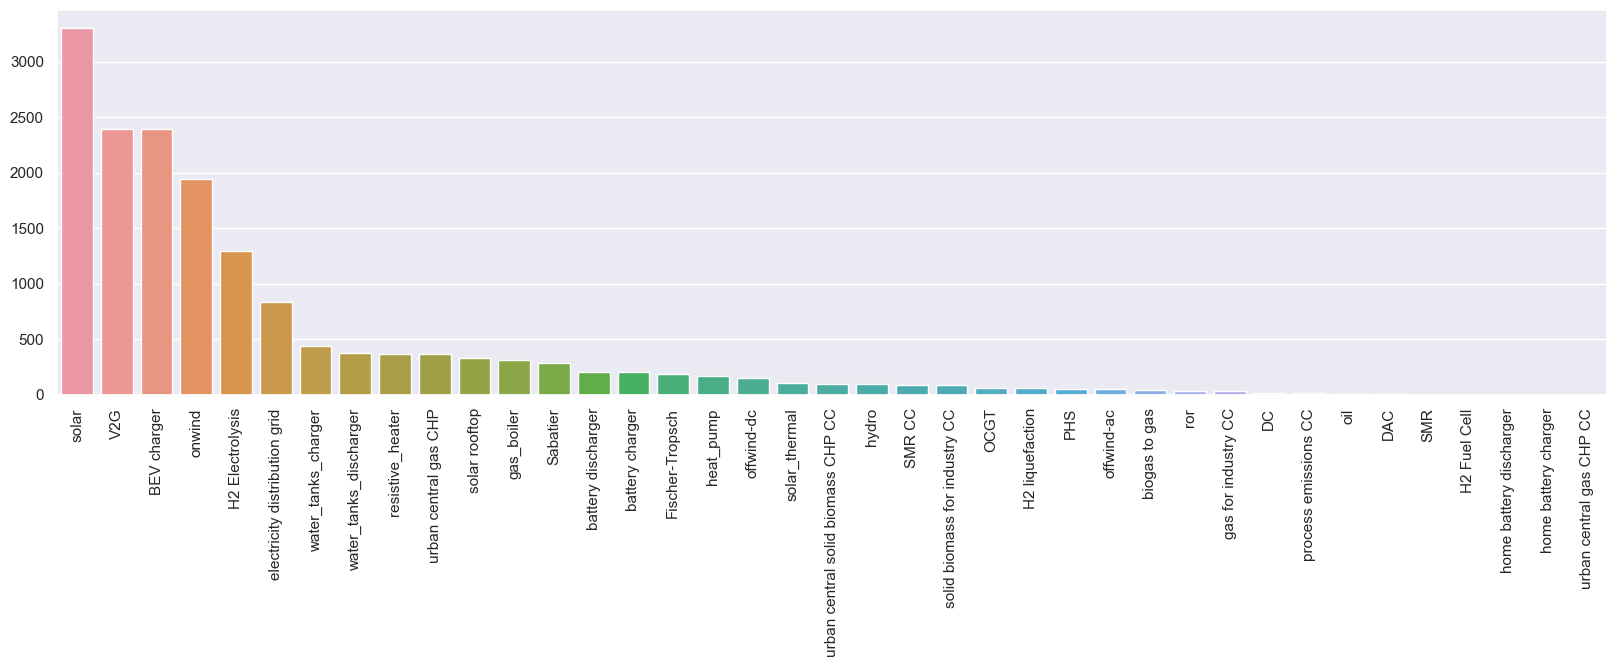

In [7]:
cap_n_no = cap_n_no.sort_values(by=0, axis='columns', ascending=False)
sns.set(rc={'figure.figsize': (20, 5)})
sns.barplot(data=cap_n_no.iloc[: , 1:40])
ticks = plt.xticks(rotation=90)
plt.show()

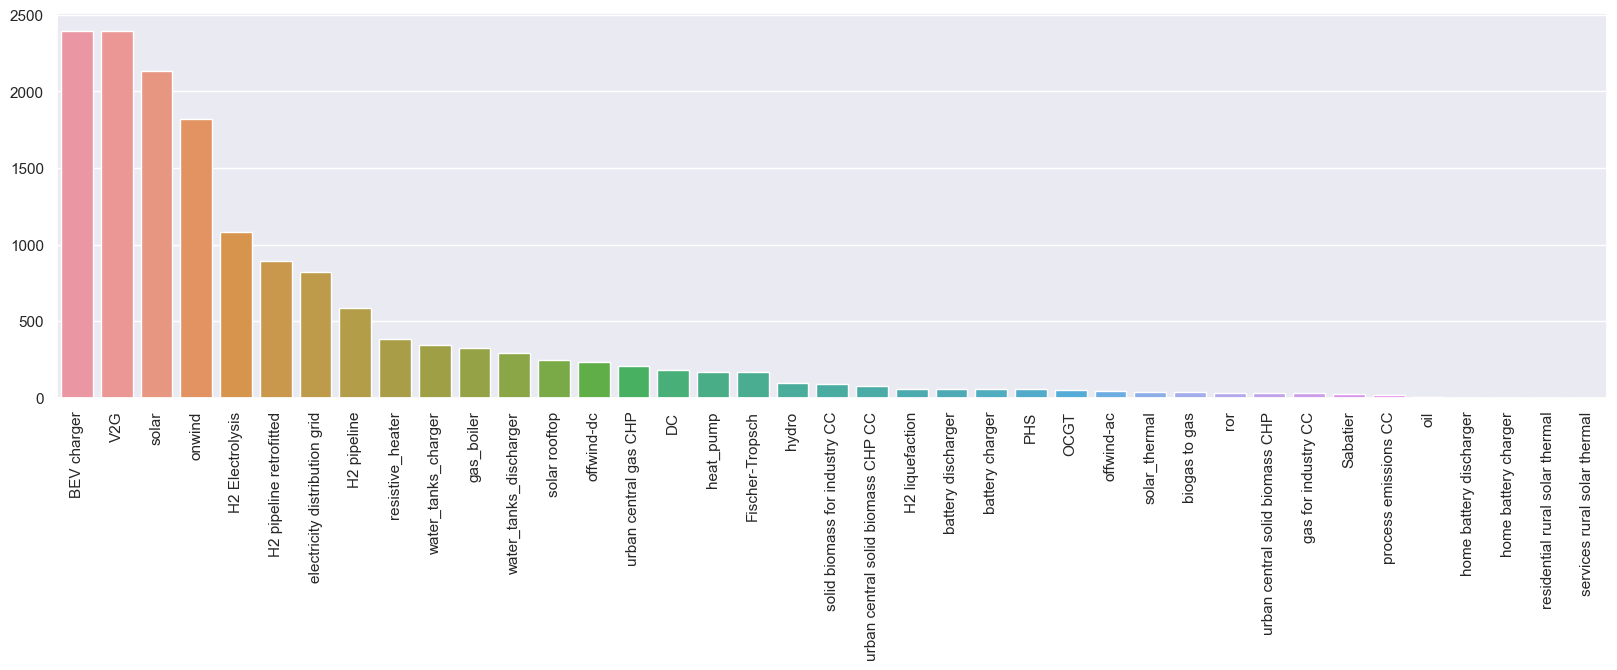

In [8]:
cap_n = cap_n.sort_values(by=0, axis='columns', ascending=False)
sns.set(rc={'figure.figsize': (20, 5)})
sns.barplot(data=cap_n.iloc[: , 1:40])
ticks = plt.xticks(rotation=90)
plt.show()

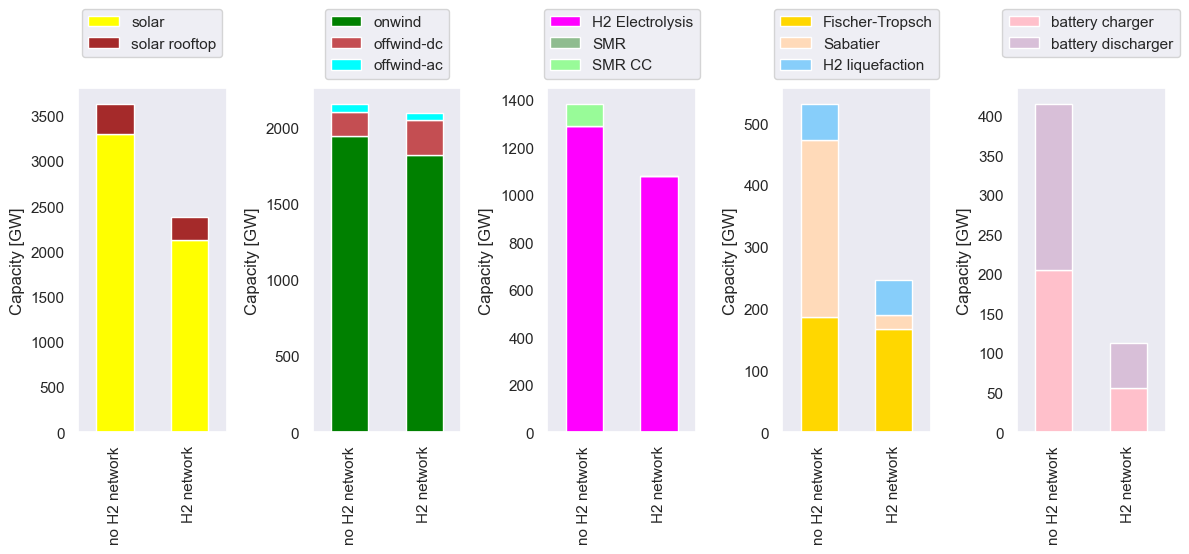

In [9]:
# thesis_plot

fig, (ax0, ax1, ax2, ax3, ax4) = plt.subplots(nrows=1, ncols=5, figsize=(12, 6))
bbox = (0.5, 1.25)

carriers = ["solar" , "solar rooftop"]
get_df(carriers).plot(ax = ax0, kind="bar", stacked=True, grid=False, color=[carrier_colors[c] for c in carriers], ylabel="Capacity [GW]")
ax0.legend(loc='upper center', bbox_to_anchor=bbox)

carriers = ["onwind", "offwind-dc", "offwind-ac"]
get_df(carriers).plot(ax = ax1, kind="bar", stacked=True, grid=False, color=[carrier_colors[c] for c in carriers], ylabel="Capacity [GW]")
ax1.legend(loc='upper center', bbox_to_anchor=bbox)

carriers = ["H2 Electrolysis", "SMR", "SMR CC"]
get_df(carriers).plot(ax = ax2, kind="bar", stacked=True, grid=False, color=[carrier_colors[c] for c in carriers], ylabel="Capacity [GW]")
ax2.legend(loc='upper center', bbox_to_anchor=bbox)

carriers = ["Fischer-Tropsch", "Sabatier", "H2 liquefaction"]
get_df(carriers).plot(ax = ax3, kind="bar", stacked=True, grid=False, color=[carrier_colors[c] for c in carriers], ylabel="Capacity [GW]")
ax3.legend(loc='upper center', bbox_to_anchor=bbox)

carriers = ["battery charger", "battery discharger"]
get_df(carriers).plot(ax = ax4, kind="bar", stacked=True, grid=False, color=[carrier_colors[c] for c in carriers], ylabel="Capacity [GW]")
ax4.legend(loc='upper center', bbox_to_anchor=bbox)

fig.tight_layout()
plt.show()

Notes:
- 'H2 pipeline', 'H2 pipeline retrofitted' are the only difference in the carriers (n1 does not have them)
- H2 Fuel Cell Capacity is not really existent


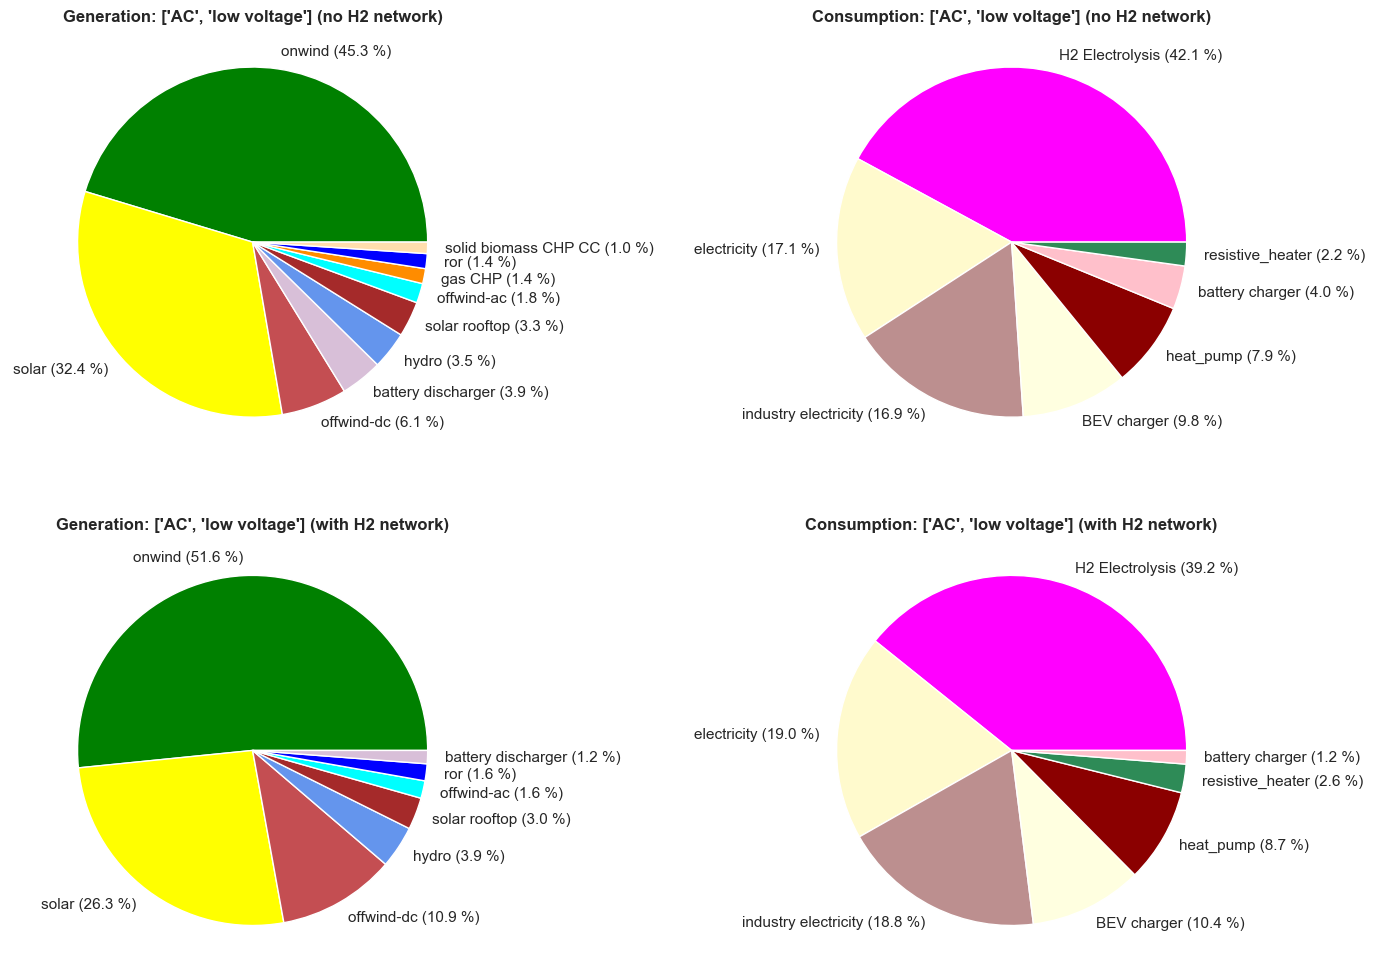

In [14]:
# thesis_plot:

fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(15, 11))

for n in [n1, n2]:

    carrier = ["AC", "low voltage"]
    nb = nodal_balance(n, carrier=carrier, time="2013", aggregate=['component', 'bus'], energy=True)
    # convert from MW to GW
    nb = nb.unstack(level=[1]) / 1000
    # condense condense_groups
    nb = get_condense_sum(nb, c1_groups, c1_groups_name)
    # rename unhandy column names
    nb.rename(columns=carrier_renaming, inplace=True)

    nb_pos = nb.sum()[nb.sum() > 0].sort_values(ascending=False)
    # exclude all shares smaller than 1 %
    nb_pos = nb_pos[(nb_pos / nb_pos.sum()) > 0.01]

    nb_neg = abs(nb.sum()[nb.sum() < 0]).sort_values(ascending=False)
    # exclude all shares smaller than 1 %
    nb_neg = nb_neg[(nb_neg / nb_neg.sum()) > 0.01]

    if n==n1:
        ax_gen=axs[0, 0]
        ax_con=axs[0, 1]
        title_gen=f"Generation: {carrier} (no H2 network)"
        title_con=f"Consumption: {carrier} (no H2 network)"

    elif n==n2:
        ax_gen=axs[1, 0]
        ax_con=axs[1, 1]
        title_gen=f"Generation: {carrier} (with H2 network)"
        title_con=f"Consumption: {carrier} (with H2 network)"

    # generation
    c = [carrier_colors[col] for col in nb_pos.index]
    percents = nb_pos.to_numpy() * 100 / nb_pos.to_numpy().sum()
    labels = ['%s (%1.1f %%)' % (l, s) for l, s in zip(nb_pos.index, percents)]

    patches, texts = ax_gen.pie(nb_pos, colors=c, startangle=0, labels=labels)
    ax_gen.axis('equal')
    ax_gen.set_title(title_gen, pad=20, fontweight="bold")

    # consumption
    c = [carrier_colors[col] for col in nb_neg.index]
    percents = nb_neg.to_numpy() * 100 / nb_neg.to_numpy().sum()
    labels = ['%s (%1.1f %%)' % (l, s) for l, s in zip(nb_neg.index, percents)]

    patches, texts = ax_con.pie(nb_neg, colors=c, startangle=0, labels=labels)
    ax_con.axis('equal')

    ax_con.set_title(title_con, pad=20, fontweight="bold")

fig.tight_layout(pad=5)
plt.show()

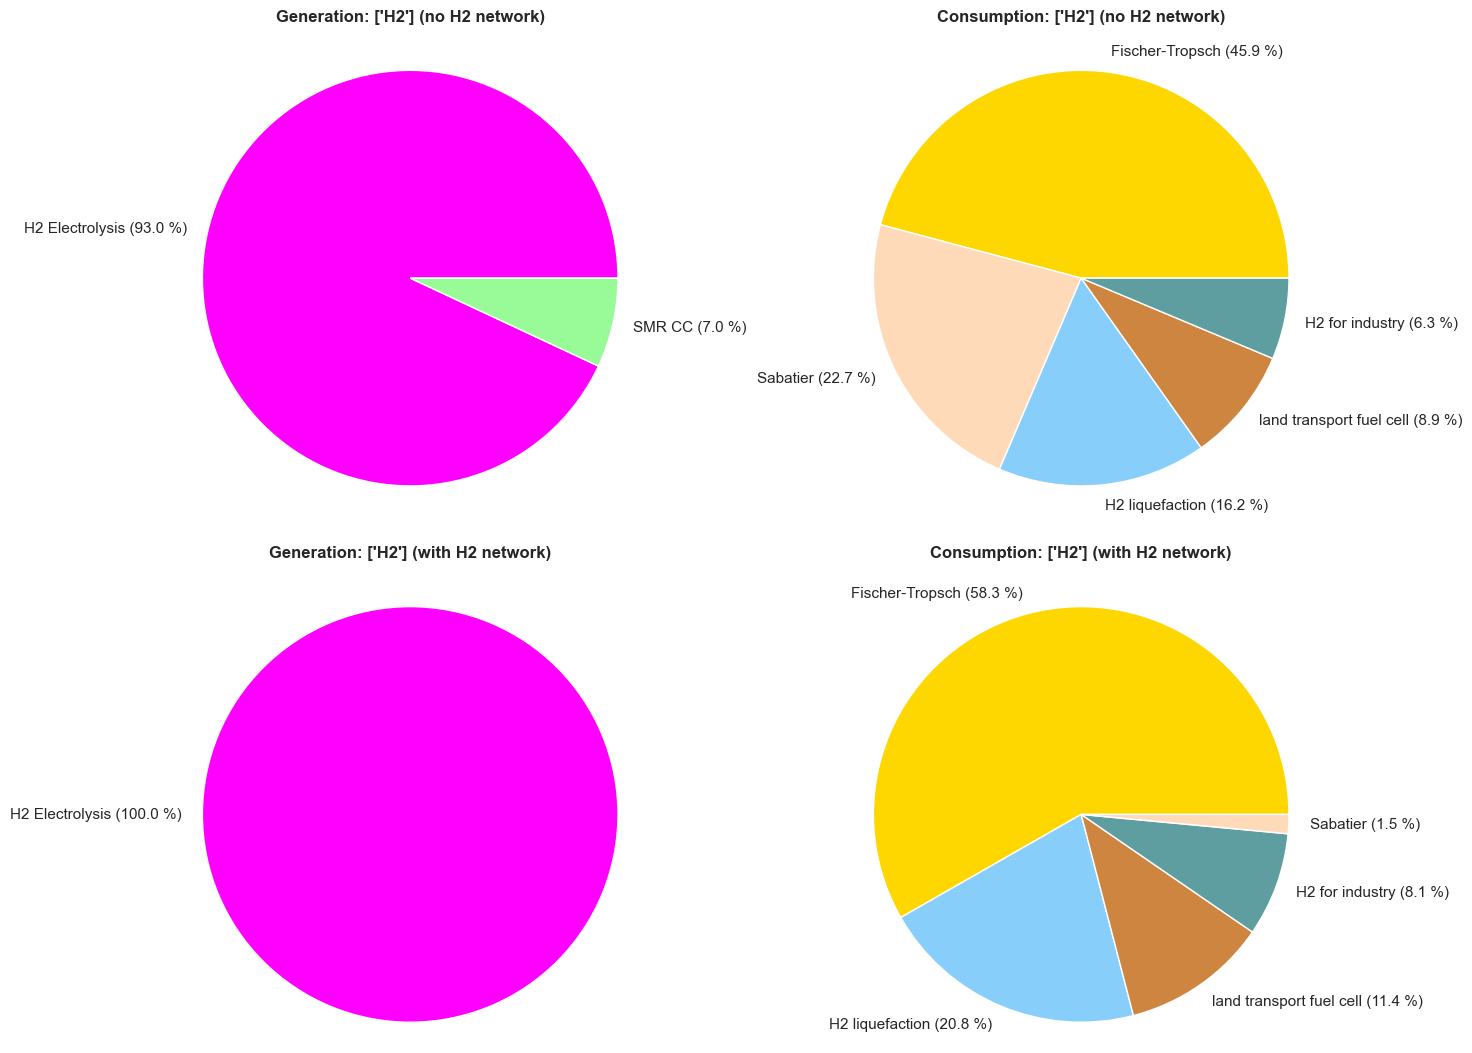

In [12]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(15, 11))

for n in [n1, n2]:

    carrier = ["H2"]
    nb = nodal_balance(n, carrier=carrier, time="2013", aggregate=['component', 'bus'], energy=True)
    # convert from MW to GW
    nb = nb.unstack(level=[1]) / 1000

    nb_pos = nb.sum()[nb.sum() > 0].sort_values(ascending=False)
    # exclude all shares smaller than 1 %
    nb_pos = nb_pos[(nb_pos / nb_pos.sum()) > 0.01]

    nb_neg = abs(nb.sum()[nb.sum() < 0]).sort_values(ascending=False)
    # exclude all shares smaller than 1 %
    nb_neg = nb_neg[(nb_neg / nb_neg.sum()) > 0.01]

    if n==n1:
        ax_gen=axs[0, 0]
        ax_con=axs[0, 1]
        title_gen=f"Generation: {carrier} (no H2 network)"
        title_con=f"Consumption: {carrier} (no H2 network)"

    elif n==n2:
        ax_gen=axs[1, 0]
        ax_con=axs[1, 1]
        title_gen=f"Generation: {carrier} (with H2 network)"
        title_con=f"Consumption: {carrier} (with H2 network)"

    # generation
    c = [carrier_colors[col] for col in nb_pos.index]
    percents = nb_pos.to_numpy() * 100 / nb_pos.to_numpy().sum()
    labels = ['%s (%1.1f %%)' % (l, s) for l, s in zip(nb_pos.index, percents)]

    patches, texts = ax_gen.pie(nb_pos, colors=c, startangle=0, labels=labels)
    ax_gen.axis('equal')
    ax_gen.set_title(title_gen, pad=20, fontweight="bold")

    # consumption
    c = [carrier_colors[col] for col in nb_neg.index]
    percents = nb_neg.to_numpy() * 100 / nb_neg.to_numpy().sum()
    labels = ['%s (%1.1f %%)' % (l, s) for l, s in zip(nb_neg.index, percents)]

    patches, texts = ax_con.pie(nb_neg, colors=c, startangle=0, labels=labels)
    ax_con.axis('equal')

    ax_con.set_title(title_con, pad=20, fontweight="bold")

fig.tight_layout(pad=2)
plt.show()

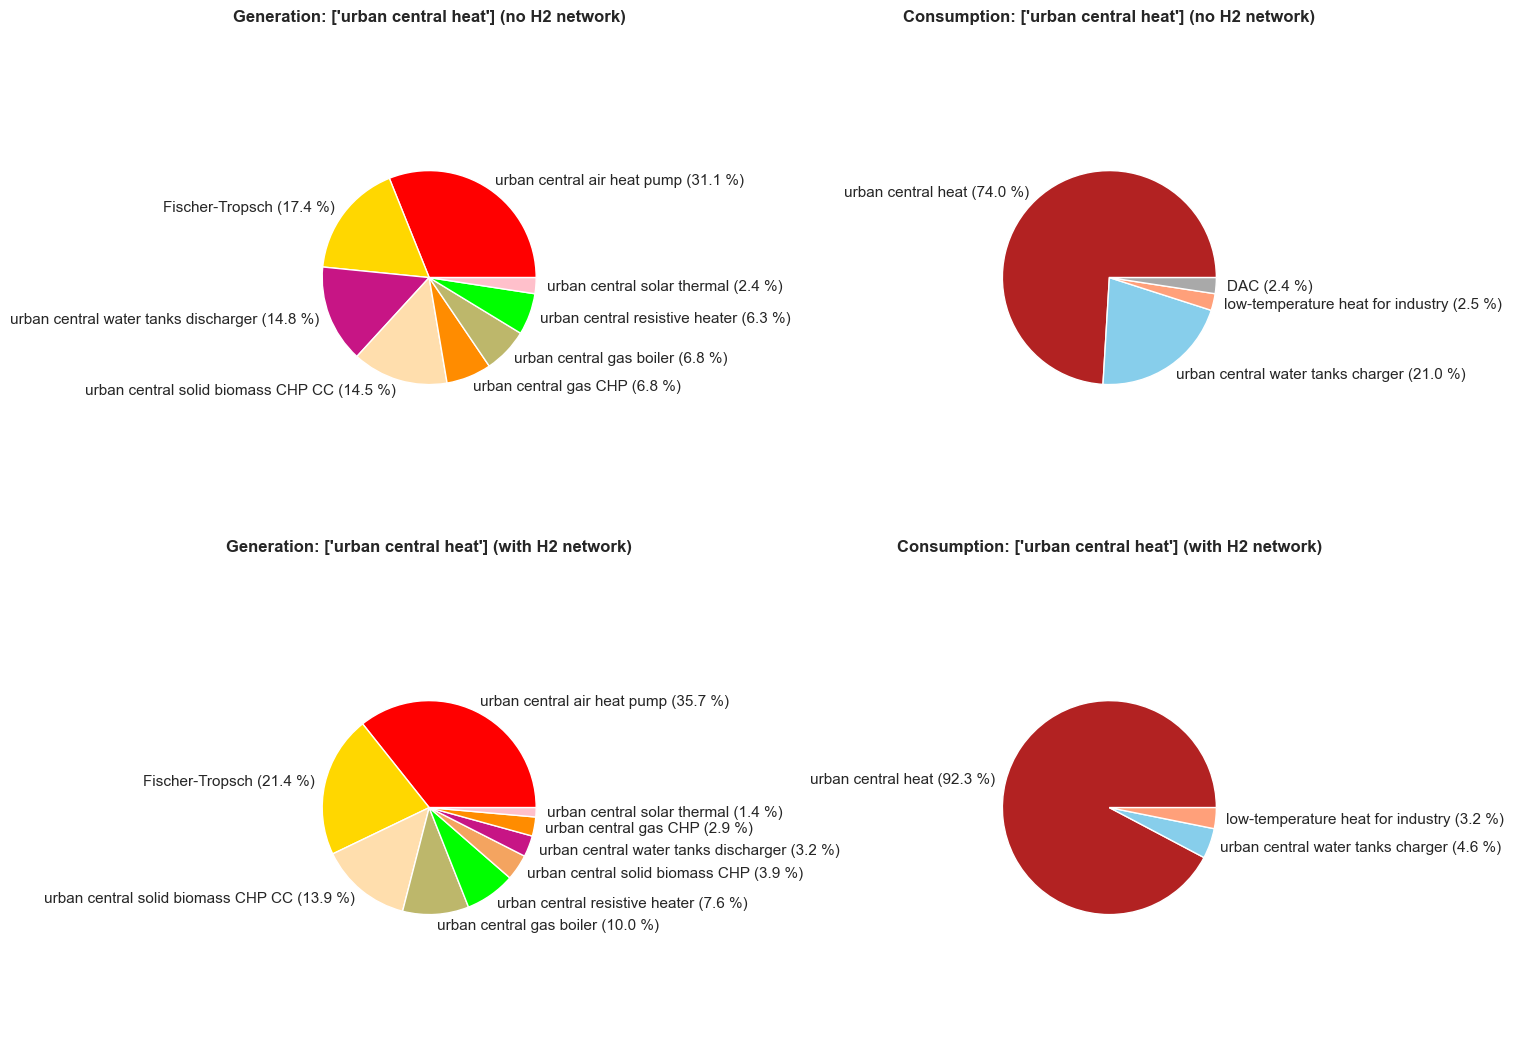

In [13]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(15, 11))

for n in [n1, n2]:

    carrier = ["urban central heat"]
    nb = nodal_balance(n, carrier=carrier, time="2013", aggregate=['component', 'bus'], energy=True)
    # convert from MW to GW
    nb = nb.unstack(level=[1]) / 1000

    nb_pos = nb.sum()[nb.sum() > 0].sort_values(ascending=False)
    # exclude all shares smaller than 1 %
    nb_pos = nb_pos[(nb_pos / nb_pos.sum()) > 0.01]

    nb_neg = abs(nb.sum()[nb.sum() < 0]).sort_values(ascending=False)
    # exclude all shares smaller than 1 %
    nb_neg = nb_neg[(nb_neg / nb_neg.sum()) > 0.01]

    if n==n1:
        ax_gen=axs[0, 0]
        ax_con=axs[0, 1]
        title_gen=f"Generation: {carrier} (no H2 network)"
        title_con=f"Consumption: {carrier} (no H2 network)"

    elif n==n2:
        ax_gen=axs[1, 0]
        ax_con=axs[1, 1]
        title_gen=f"Generation: {carrier} (with H2 network)"
        title_con=f"Consumption: {carrier} (with H2 network)"

    # generation
    c = [carrier_colors[col] for col in nb_pos.index]
    percents = nb_pos.to_numpy() * 100 / nb_pos.to_numpy().sum()
    labels = ['%s (%1.1f %%)' % (l, s) for l, s in zip(nb_pos.index, percents)]

    patches, texts = ax_gen.pie(nb_pos, colors=c, startangle=0, labels=labels)
    ax_gen.axis('equal')
    ax_gen.set_title(title_gen, pad=20, fontweight="bold")

    # consumption
    c = [carrier_colors[col] for col in nb_neg.index]
    percents = nb_neg.to_numpy() * 100 / nb_neg.to_numpy().sum()
    labels = ['%s (%1.1f %%)' % (l, s) for l, s in zip(nb_neg.index, percents)]

    patches, texts = ax_con.pie(nb_neg, colors=c, startangle=0, labels=labels)
    ax_con.axis('equal')

    ax_con.set_title(title_con, pad=20, fontweight="bold")

fig.tight_layout(pad=2)
plt.show()

# Fischer Tropsch nebenprdukt Heat